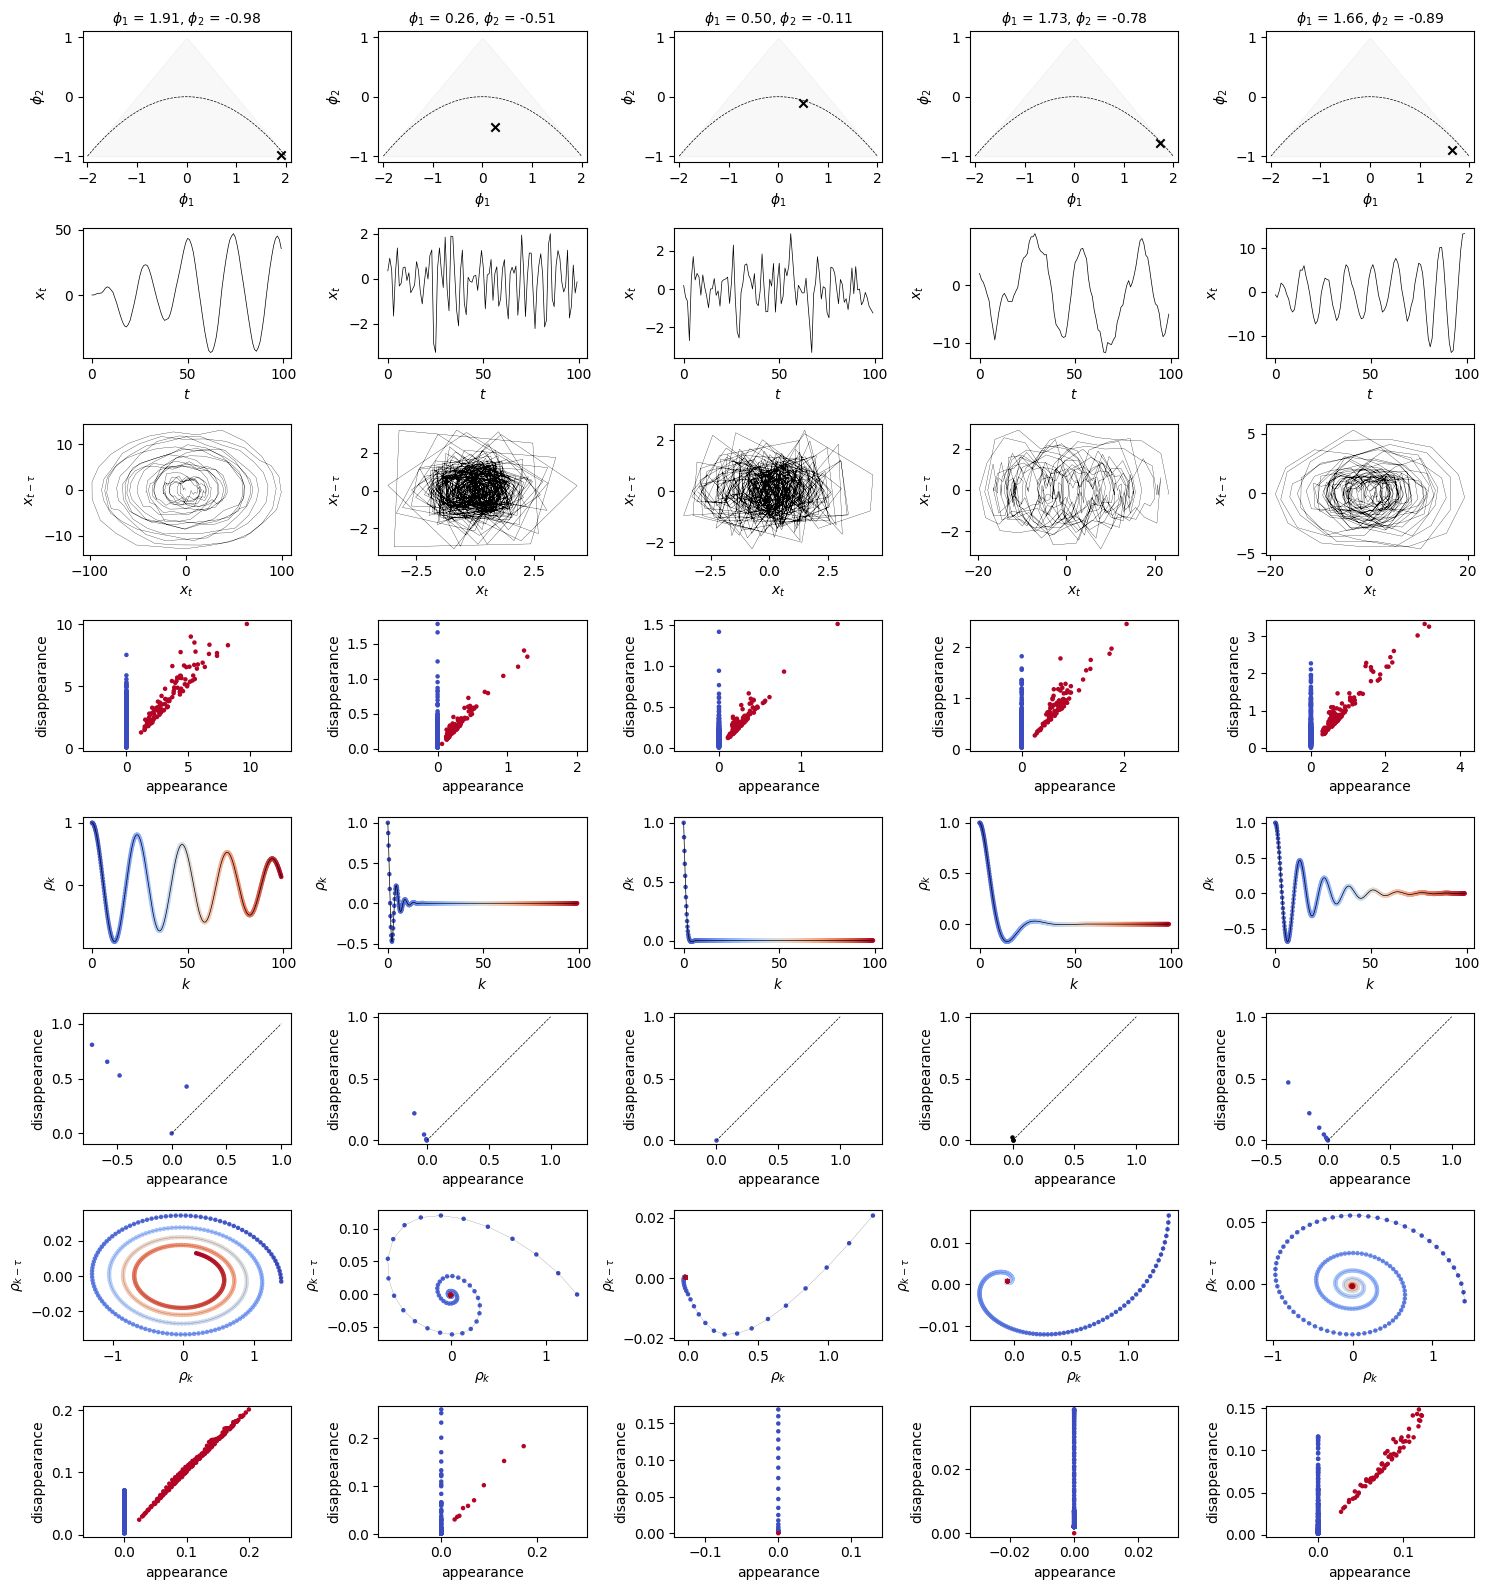

In [1]:
import matplotlib.pyplot as plt
import nb_utils
import numpy as np
from gtda.homology import VietorisRipsPersistence
from gtda.time_series import SingleTakensEmbedding
from scipy.interpolate import CubicSpline
from sklearn.decomposition import PCA
from src import acf_utils, plts, sim

plt.rcParams["image.cmap"] = "coolwarm"


emb = SingleTakensEmbedding(time_delay=1, dimension=2, n_jobs=-1)
pca = PCA(n_components=2)
vr = VietorisRipsPersistence(metric="euclidean", homology_dimensions=(0, 1), n_jobs=-1)

n_sims, n_lags, n_interp = 5, 100, 5
ks = np.linspace(0, n_lags - 1, n_lags)
ks_interp = np.linspace(0, n_lags - 1, (n_lags * n_interp))

fig, axs = plt.subplots(nrows=8, ncols=n_sims, figsize=(15, 16))
plot_kwargs = dict(ls="-", lw=0.5)
scatter_kwargs = dict(s=5)

for idx in range(n_sims):
    phis = nb_utils.gen_ar2_coeffs(oscillatory=True, phi1="positive", random_seed=idx + 10)

    X = sim.sim_ar(phis, n_lags * n_interp, random_seed=idx).squeeze()
    X_emb = emb.fit_transform(X)
    X_emb = pca.fit_transform(X_emb)
    X_vr = vr.fit_transform(X_emb[None, ...])

    X_acf = acf_utils.ar_to_acf(phis, n_lags=n_lags)
    cs = CubicSpline(ks, X_acf)
    X_acf = cs(ks_interp)
    X_acf_emb = emb.fit_transform(X_acf)
    X_acf_emb = pca.fit_transform(X_acf_emb)
    weights = 1 - np.arange(len(X_acf_emb)) / (len(X_acf_emb))
    X_acf_emb = np.hstack((X_acf_emb, weights.reshape(-1, 1)))
    X_acf_ssf = nb_utils.sublevel_set_filtration(X_acf)
    X_acf_vr = vr.fit_transform(X_acf_emb[None, ...])

    # stationarity triangle
    axs[0, idx].set_title(rf"$\phi_1$ = {phis[0]:.2f}, $\phi_2$ = {phis[1]:.2f}", fontsize=10)
    plts.plot_stationarity_triangle(axs[0, idx], fill_alpha=0.05, annotate=False)
    axs[0, idx].scatter(phis[0], phis[1], c="k", marker="x")

    # x_t
    axs[1, idx].plot(X[:n_lags], c="k", **plot_kwargs)
    axs[1, idx].set_xlabel(r"$t$")
    axs[1, idx].set_ylabel(r"$x_t$")

    # x_t embedding
    axs[2, idx].plot(X_emb[:, 0], X_emb[:, 1], c="k", lw=0.2)
    axs[2, idx].set_xlabel(r"$x_t$")
    axs[2, idx].set_ylabel(r"$x_{t-\tau}$")

    # x_t embedding vietoris-rips
    axs[3, idx].scatter(X_vr[:, :, 0], X_vr[:, :, 1], c=X_vr[:, :, 2], **scatter_kwargs)
    axs[3, idx].axis("equal")
    axs[3, idx].set_xlabel("appearance")
    axs[3, idx].set_ylabel("disappearance")

    # rho_t
    axs[4, idx].plot(ks_interp, X_acf, c="k", **plot_kwargs)
    axs[4, idx].scatter(ks_interp, X_acf, c=ks_interp, **scatter_kwargs)
    axs[4, idx].set_xlabel(r"$k$")
    axs[4, idx].set_ylabel(r"$\rho_k$")

    # rho_t sublevel set
    axs[5, idx].scatter(
        X_acf_ssf[:, :, 0], X_acf_ssf[:, :, 1], c=X_acf_ssf[:, :, 2], **scatter_kwargs
    )
    axs[5, idx].axis("equal")
    axs[5, idx].plot([0, 1], [0, 1], "k--", lw=0.5)
    axs[5, idx].set_xlabel("appearance")
    axs[5, idx].set_ylabel("disappearance")

    # rho_t embedding
    axs[6, idx].plot(X_acf_emb[:, 0], X_acf_emb[:, 1], c="k", lw=0.1)
    axs[6, idx].scatter(X_acf_emb[:, 0], X_acf_emb[:, 1], c=X_acf_emb[:, 2] * -1, **scatter_kwargs)
    axs[6, idx].set_xlabel(r"$\rho_k$")
    axs[6, idx].set_ylabel(r"$\rho_{k-\tau}$")

    # rho_t embedding vietoris-rips
    axs[7, idx].scatter(X_acf_vr[:, :, 0], X_acf_vr[:, :, 1], c=X_acf_vr[:, :, 2], **scatter_kwargs)
    axs[7, idx].axis("equal")
    axs[7, idx].set_xlabel("appearance")
    axs[7, idx].set_ylabel("disappearance")

fig.tight_layout()